## Installations

In [1]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-07 15:58:11


In [ ]:
! pip install skorch
! pip install pytorch-tabnet
! pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 120 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## *Imports*

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import seaborn as sb
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.tab_model import TabNetClassifier
from skorch import NeuralNetClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score,recall_score,accuracy_score,roc_auc_score,precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive',)

Mounted at /content/drive


## Loading of Dataset

In [ ]:
fname = f"/content/drive/MyDrive/BT4222/data/feature_eng_combined_v2.csv"
df = pd.read_csv(fname)
#Feature selection for training
df_model = df.copy().drop(columns=['Unnamed: 0', 'id', 'name', 'artists', 'artist_ids', 'release_date_x', 'release_date', 'date', 'lyrics', 'non_stop_lyrics', 'release_month', 'sentiment'])

#Split train and test set
X, y = df_model.drop(columns=['target']), df_model['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Loading of Models

Tuned Naive Bayes Model without SMOTE


In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_gs_nb_tuned.sav'
Tuned_NB_model = pickle.load(open(filename, 'rb'))

Tuned DNN Model with SMOTE

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_nn_w_tuning.sav'
Tuned_DNN_w_SMOTE_model = pickle.load(open(filename, 'rb'))

TabNet With SMOTE

In [ ]:
Tabnet_clf = TabNetClassifier()
saved_filepath = f'/content/drive/MyDrive/BT4222/models/tabnet_model_SMOTE.zip'
Tabnet_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Ensembled (RFC, GradientBoosted, ExtraTrees) w Oversample (NOT SMOTE) and MinMaxScale

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/ensembled_over.sav'
Ensembled_Trees_model = pickle.load(open(filename, 'rb'))

RandomForest (Oversampled) w Scaling

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/rfc_over_tuned.sav'
Random_forest_model = pickle.load(open(filename, 'rb'))

XGBoost Smote Scaled

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_xgboost_tuned_smote_npy_ver.sav'
XGB_SMOTE_Scaled = pickle.load(open(filename, 'rb'))

Tuned SVM Classifier

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_svc_tuned.sav'
Tuned_SVC = pickle.load(open(filename, 'rb'))

In [ ]:
Tuned_DNN_w_SMOTE_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 320)               15040     
                                                                 
 dense_18 (Dense)            (None, 480)               154080    
                                                                 
 dense_19 (Dense)            (None, 32)                15392     
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 184,545
Trainable params: 184,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import keras.backend as K
print(K.eval(Tuned_DNN_w_SMOTE_model.optimizer.lr))

1e-04


## Voting Classifier Building

Estimators

In [ ]:
estimators_list = [
    Tuned_NB_model,
    Tuned_DNN_w_SMOTE_model,
    Tabnet_clf,
    Ensembled_Trees_model,
    Random_forest_model,
    XGB_SMOTE_Scaled,
    Tuned_SVC
]

In [ ]:
import inspect
inspect.getfullargspec(EnsembleVoteClassifier)

FullArgSpec(args=['self', 'clfs', 'voting', 'weights', 'verbose', 'refit'], varargs=None, varkw=None, defaults=('hard', None, 0, True), kwonlyargs=[], kwonlydefaults=None, annotations={})

Hard Voting

In [ ]:
eclf = EnsembleVoteClassifier(clfs=estimators_list, refit=False)

In [ ]:
eclf = eclf.fit(X_train, y_train)

In [ ]:
eclf.predict(X_train)

Hard Voting(Manual)

In [ ]:
estimators = [
    ('NB',Tuned_NB_model),
    ('DNN',Tuned_DNN_w_SMOTE_model),
    ('TBNT',Tabnet_clf),
    ('Ensb',Ensembled_Trees_model),
    ('RndmF',Random_forest_model),
    ('XGB',XGB_SMOTE_Scaled),
    ('SVC',Tuned_SVC)
]
hard_results_list = []
for i in range(0,len(estimators)):
  temp_estimator = estimators[i][1]
  y_pred_hard_component = temp_estimator.predict(X_test)
  if i==1:
    y_pred_hard_component = (y_pred_hard_component > 0.5).astype("int32")
    y_pred_hard_component = y_pred_hard_component.reshape(-1)
  hard_results_list.append(y_pred_hard_component)


base_result_list = np.vstack(hard_results_list).transpose()
output_array = []
for i in base_result_list:
  if sum(i) >= 4:
    output_array.append(1)
  else:
    output_array.append(0)
output_array = np.asarray(output_array)

587/587 [==============================] - 2s 2ms/step


              precision    recall  f1-score   support

           0       0.95      0.95      0.95     15981
           1       0.69      0.69      0.69      2775

    accuracy                           0.91     18756
   macro avg       0.82      0.82      0.82     18756
weighted avg       0.91      0.91      0.91     18756

Accuracy: 0.9087758583919813
Precision: 0.6926140477914554
Recall: 0.6893693693693693
F1-score: 0.6909878995846126


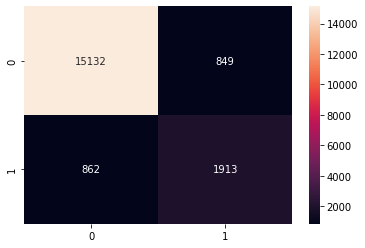

In [ ]:
print(classification_report(y_test,output_array))
print(f"Accuracy: {accuracy_score(y_test,output_array)}")
print(f"Precision: {precision_score(y_test,output_array)}")
print(f"Recall: {recall_score(y_test,output_array)}")
print(f"F1-score: {f1_score(y_test,output_array)}")


cf_matrix = confusion_matrix(y_test,output_array)  
sb.heatmap(cf_matrix, annot=True, fmt='g')